## The first algorithm

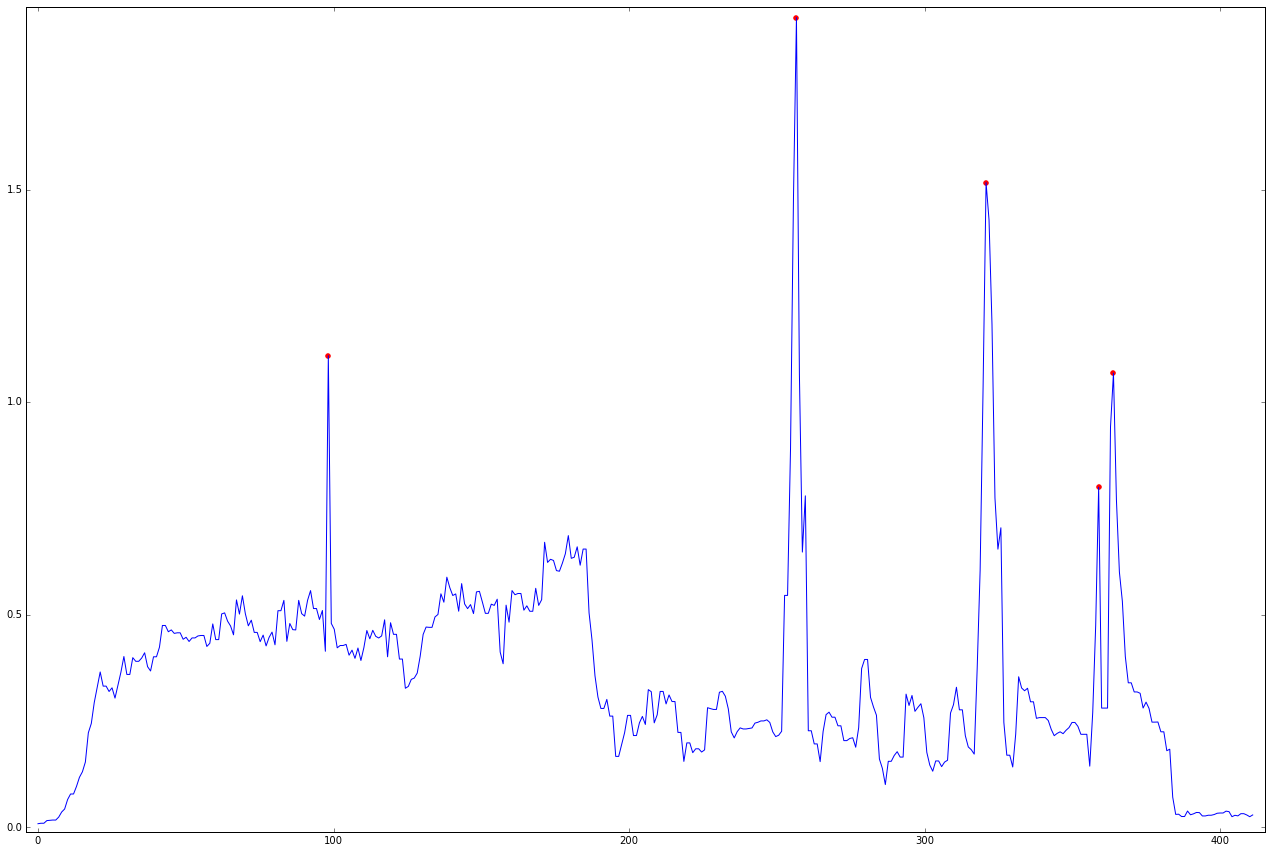

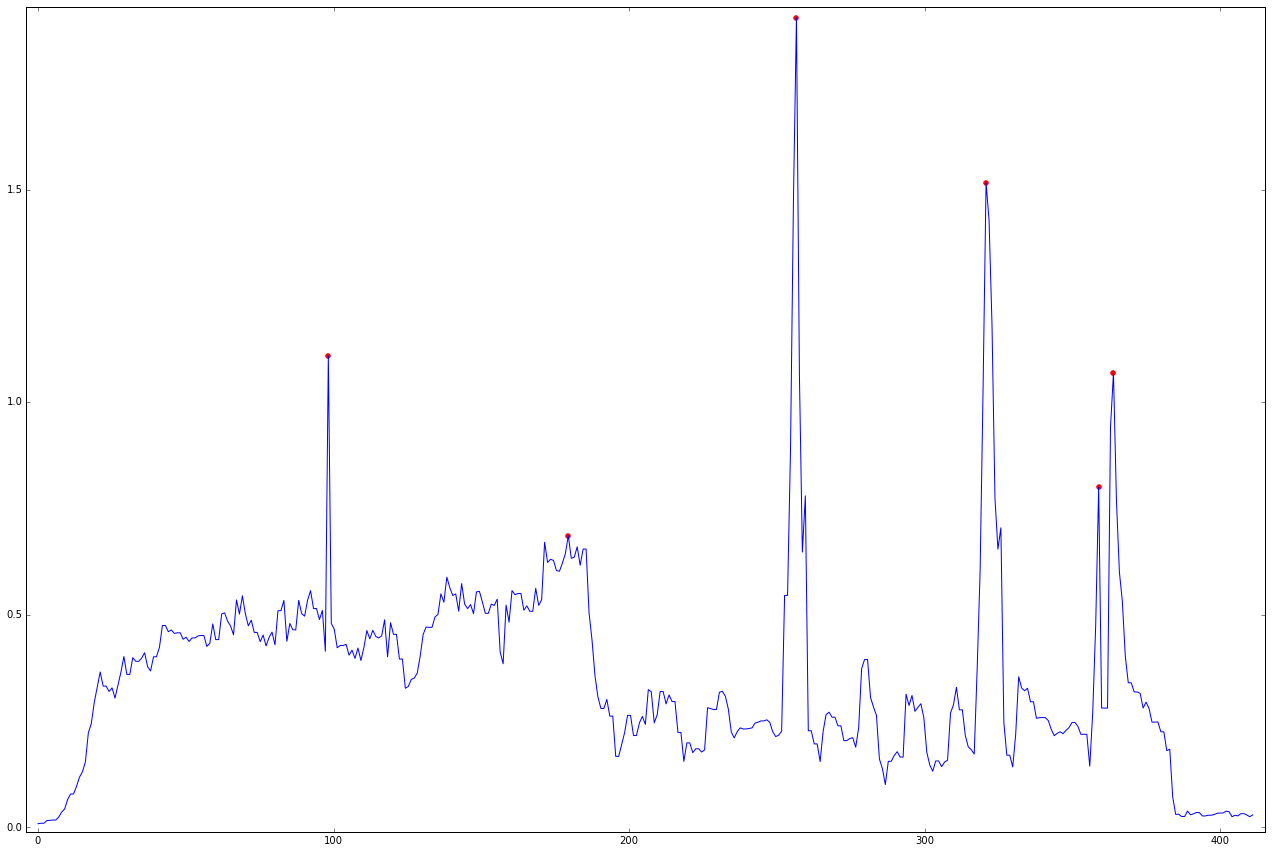

In [126]:
def peaksdetect(file_name, delta, is_header=False, skiprows=0):
    """    
    Returns a plot with detected peaks.
    Note:
        The first column in the file with data corresponds to x-axis data and the second column consists data for y-axis.
    Args:
        file_name (str) - the path to the file with data for plotting;
        delta (float or int, positive) - a parameter to control sensitivity vs time-delay;
        is_header (bool) - True if file with data consists header, else False;
        skiprows (int) - indicates the number of rows (disregarding the header) in the document that you want to miss.
    Description:
        Function PEAKDET finds the local maxima ("peaks") of the vector y, the components of which 
        are contained in the second column of the document "file_name".
        The array PEAKS represents a list with tuples (respectively x and y coordinate of peaks).
        A point is considered a maximum peak if it has the maximal value, 
        and was preceded (to the left) by a value lower by DELTA.
    """
    
    import csv
    import numpy as np
    import matplotlib.pyplot as plt
    
    if (not np.isscalar(delta)) or (delta <= 0):
        raise Exception('Pay attention: delta should be a positive scalar.')
        
    # Reading of the file data: the first column corresponds to x axis, the second column - to y axis
    x, y = [], []
    with open(file_name, 'rb') as f:
        reader = csv.reader(f.read().splitlines())
        for num, row in enumerate(reader):
            if is_header and num == 0: continue
            if num < skiprows: continue
            x.append(row[0])
            y.append(float(row[1]))
    x, y = np.asarray(x), np.asarray(y)
    x_linsp = np.linspace(0, len(x), len(x))
    
    if (len(x) != len(y)):
        raise Exception('Check the file "{}". Amount of rows for two columns should be equals.'.format(file_name))  
        
    # Variables for finding the peak points
    peaks = []    
    min_p, max_p = np.Inf, -np.Inf
    min_pos, max_pos = np.NaN, np.NaN
    find_max = True
    
    for i in np.arange(len(y)):
        if y[i] > max_p:
            max_p, max_pos = y[i], x_linsp[i]
        elif y[i] < min_p:
            min_p, min_pos = y[i], x_linsp[i]
        if find_max:
            if y[i] < max_p - delta:
                peaks.append((max_pos, max_p))
                min_p, min_pos = y[i], x_linsp[i]
                find_max = False
        else:
            if y[i] > min_p + delta:
                max_p, max_pos = y[i], x_linsp[i]
                find_max = True


    fig = plt.figure(figsize=(18,12))
    plt.plot(x_linsp, y)
    plt.scatter(np.array(peaks)[:,0], np.array(peaks)[:,1], color='red')
    # To display values of x-axis according to the first column of the document you should uncomment the below line
    #plt.xticks(x_linsp, x, rotation=70)
    plt.tight_layout()
    plt.margins(0.01)
    plt.show()
    
peaksdetect('mars_mhh.csv', 0.5)
peaksdetect('mars_mhh.csv', 0.25)

## The second algorithm

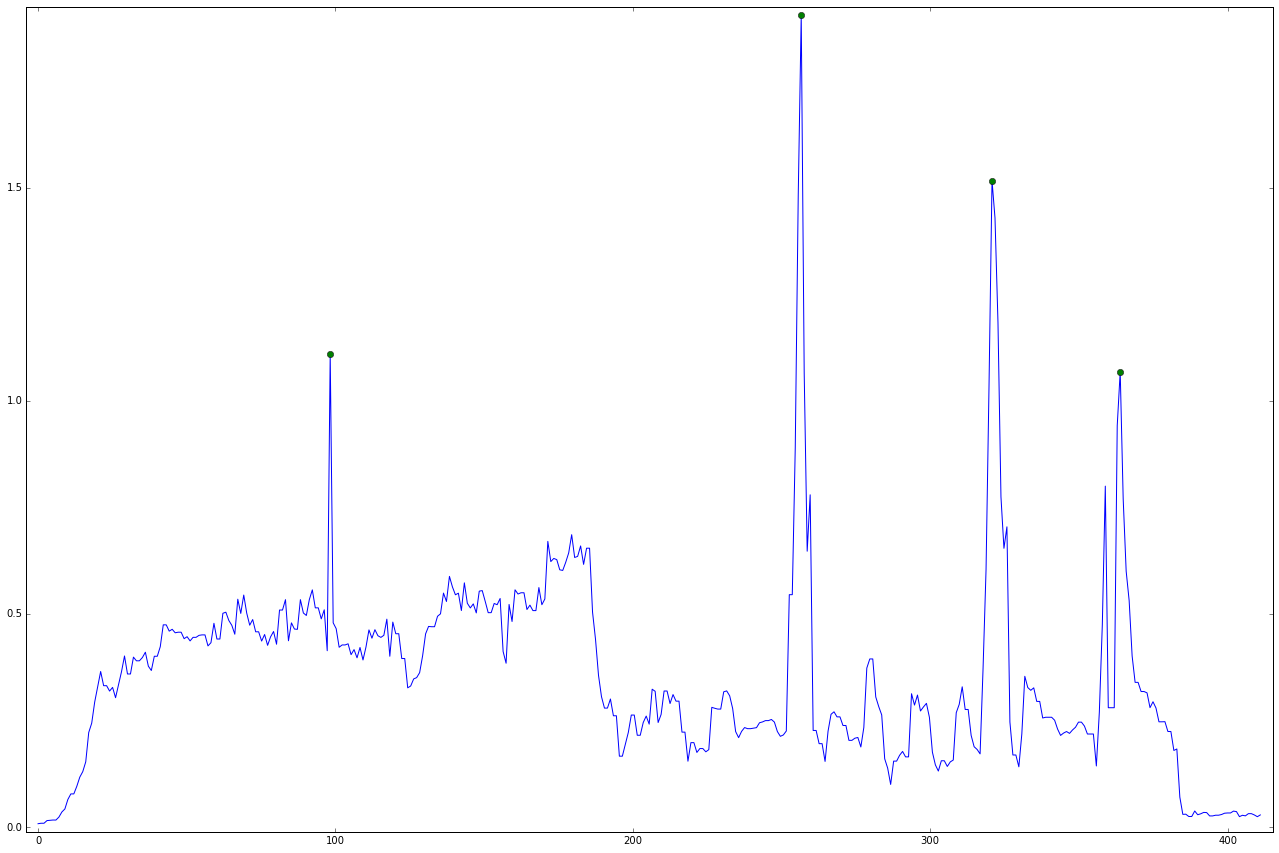

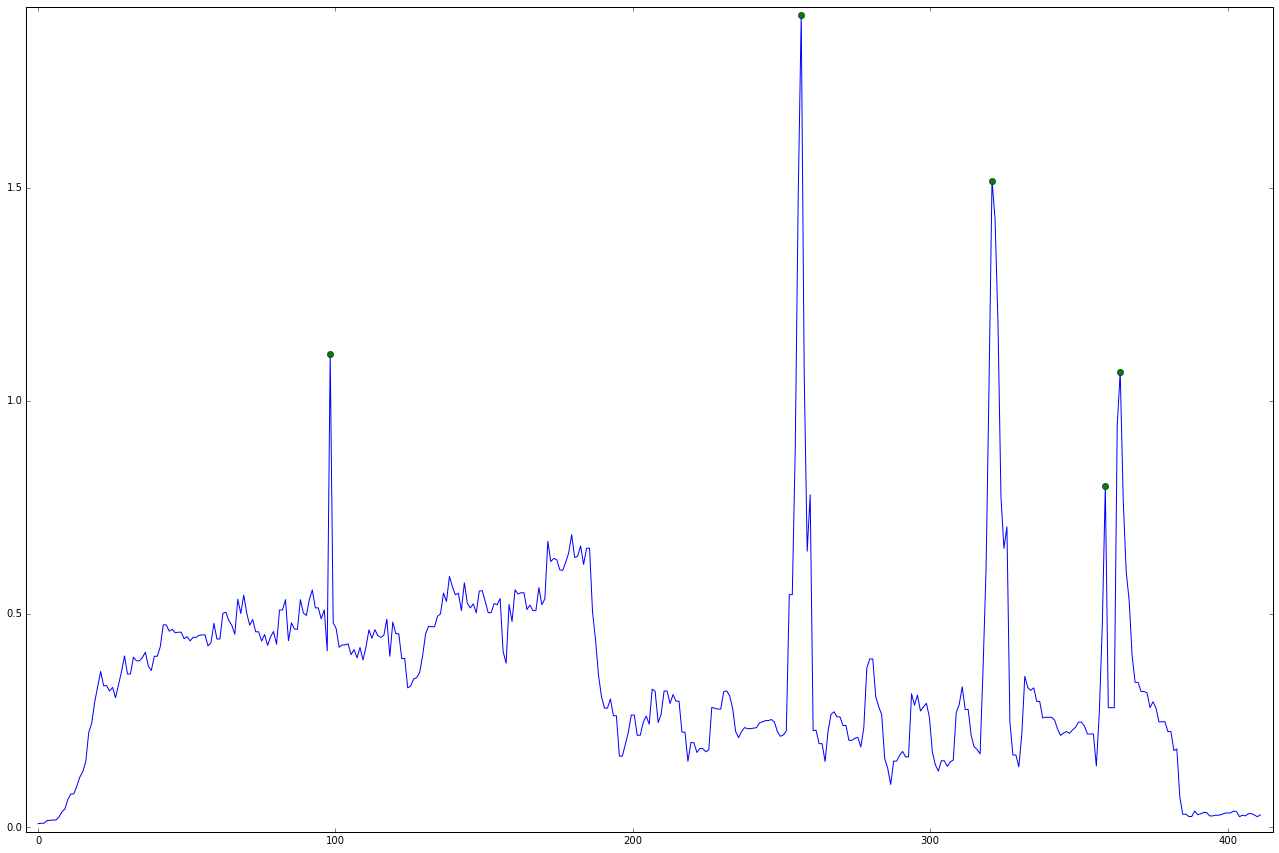

In [130]:
def peaksdetect(file_name, k, h, is_header=False, skiprows=0):
    """    
    Returns a plot with detected peaks.
    Note:
        The first column in the file with data corresponds to x-axis data and the second column consists data for y-axis.
    Args:
        file_name (str) - the path to the file with data for plotting;
        k (int, positive) - temporal neighbours of each point;
        h (float or int, positive) - some constant;
        is_header (bool) - True if file with data consists header, else False;
        skiprows (int) - indicates the number of rows (disregarding the header) in the document that you want to miss.
    Description:
        This algorithm was proposed by G. H. Palshikar in the paper 
        "Simple Algorithms for Peak Detection in Time-Series"
        The paper is available here:
        http://www.researchgate.net/publication/228853276_Simple_Algorithms_for_Peak_Detection_in_Time-Series
    """
    
    import csv
    import numpy as np
    import matplotlib.pyplot as plt
    
    def S1(i, k, arr):
        """
        Returns average value of maxima differences of k neighbouring points around the i-th point (left and right).
        Args:
            i (int, positive) - position number of the point;
            k (int, positive) - temporal neighbours of i-th point;
            arr (list) - array with points' y-components.
        Description:
            If i-th point is the first or the last, we consider neighbouring points 
            only right side or left side, respectively.
            If i-th point have neighbours amount in left or right side less then k, 
            we take into account all these neighbouring points.
        """
        
        left_bound = k if i-k>=0 else i
        right_bound = k if i+k<len(arr) else len(arr)-i-1
        if i == 0:
            return max([arr[i] - arr[i+j] for j in range(1, right_bound+1)])
        elif i == len(arr)-1:
            return max([arr[i] - arr[i-j] for j in range(1, left_bound+1)])
        else:
            return (max([arr[i] - arr[i-j] for j in range(1, left_bound+1)]) + 
                    max([arr[i] - arr[i+j] for j in range(1, right_bound+1)])
                   ) * 0.5

    if (not np.isscalar(h)) or (h <= 0):
        raise Exception('Pay attention: parametr h should be a positive scalar.') 
    if (not np.isscalar(k)) or (k <= 0):
        raise Exception('Pay attention: parametr k should be a positive scalar.') 
                       
    # Reading of the file data: the first column corresponds to x axis, the second column - to y axis
    x, y = [], []
    with open(file_name, 'rb') as f:
        reader = csv.reader(f.read().splitlines())
        for num, row in enumerate(reader):
            if is_header and num == 0: continue
            if num < skiprows: continue
            x.append(row[0])
            y.append(float(row[1]))
    x_linsp = np.linspace(0, len(x), len(x))
    
    if (len(x) != len(y)):
        raise Exception('Check the file "{}". Amount of rows for two columns should be equals.'.format(file_name)) 

    # Compute peak function value for each of len(y) points in y
    vals = [S1(i, k, y) for i in range(len(y))]
    
    # Compute the mean and standard deviation of all positive values in array vals
    mean = np.mean(filter(lambda x: x > 0, vals))
    std = np.std(filter(lambda x: x > 0, vals))
    
    # Remove local peaks which are “small” in global context 
    peaks = [(i, y[i], x_linsp[i]) for i in range(len(y)) if vals[i] > 0 and (vals[i] - mean) > (h * std)]
    
    # Retain only one peak out of any set of peaks within distance k of each other
    i = 0
    while i < len(peaks):    
        for j, peakj in enumerate(peaks):
            if peaks[i][0] != peakj[0]:
                if abs(peaks[i][0] - peakj[0]) <= k:
                    if peaks[i][1] >= peakj[1]:
                        del peaks[j]
                    else:
                        del peaks[i]
                        i -= 1
                        break
        i += 1
                    
       
    fig = plt.figure(figsize=(18,12))
    plt.plot(x_linsp, y, '-', 
             np.array(peaks)[:,2], np.array(peaks)[:,1], 'o')
    # To display values of x-axis according to the first column of the document you should uncomment the below line
    #plt.xticks(x_linsp, x, rotation=70)
    plt.tight_layout()
    plt.margins(0.01)
    plt.show()
    
peaksdetect('mars_mhh.csv', 5, 1.5)
peaksdetect('mars_mhh.csv', 3, 2.5)

In [113]:
import csv
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

"""
Savitzky Golay filtering
"""
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError as msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    
    order_range = range(order+1)
    half_window = (window_size -1) // 2
        # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
        # pad the signal at the extremes with
        # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

"""
Peaks detection according to Palshikar algorithm
"""
def peaks_detection(y, k, h):   
    """    
    Returns list of tuples of peaks in the form (the point number in series, x-coordinate, y-coordinate).
    Args:
        y - data vector;
        k (int, positive) - temporal neighbours of each point;
        h (float or int, positive) - some constant;
    Description:
        This algorithm was proposed by G. H. Palshikar in the paper 
        "Simple Algorithms for Peak Detection in Time-Series"
        The paper is available here:
        http://www.researchgate.net/publication/228853276_Simple_Algorithms_for_Peak_Detection_in_Time-Series
    """
        
    def S1(i, k, arr):    # additional function
        """
        Returns average value of maxima differences of k neighbouring points around the i-th point (left and right).
        Args:
            i (int, positive) - position number of the point;
            k (int, positive) - temporal neighbours of i-th point;
            arr (list) - array with points' y-components.
        Description:
            If i-th point is the first or the last, we consider neighbouring points 
            only right side or left side, respectively.
            If i-th point have neighbours amount in left or right side less then k, 
            we take into account all these neighbouring points.
        """
        
        left_bound = k if i-k>=0 else i
        right_bound = k if i+k<len(arr) else len(arr)-i-1
        if i == 0:
            return max([arr[i] - arr[i+j] for j in range(1, right_bound+1)])
        elif i == len(arr)-1:
            return max([arr[i] - arr[i-j] for j in range(1, left_bound+1)])
        else:
            return (max([arr[i] - arr[i-j] for j in range(1, left_bound+1)]) + 
                    max([arr[i] - arr[i+j] for j in range(1, right_bound+1)])
                   ) * 0.5
        
    x = np.linspace(0, len(y), len(y))
        # Compute peak function value for each of len(y) points in y
    vals = [S1(i, k, y) for i in range(len(y))]
        # Compute the mean and standard deviation of all positive values in array vals
    mean = np.mean(filter(lambda x: x > 0, vals))
    std = np.std(filter(lambda x: x > 0, vals))
        # Remove local peaks which are “small” in global context 
    peaks = [(i, x[i], y[i]) for i in range(len(y)) if vals[i] > 0 and (vals[i] - mean) > (h * std)]
        # Retain only one peak out of any set of peaks within distance k of each other
    i = 0
    while i < len(peaks):    
        for j, peakj in enumerate(peaks):
            if peaks[i][0] != peakj[0]:
                if abs(peaks[i][0] - peakj[0]) <= k:
                    if peaks[i][2] >= peakj[2]:
                        del peaks[j]
                    else:
                        del peaks[i]
                        i -= 1
                        break
        i += 1
        # return list with tuples of such form (x_coordinate, y_coordinate)
    return peaks

"""
Determining of angles of inclination on both sides of the peak
"""
def inclination_angles(point, deltaL, deltaR, y, in_radians=True):
    """ 
    Returns the dict with right and left inclination angles in radians if in_radians=True (default), .
    Args:
        point (tuple or list with 3 arguments) - position of the point with data 
            (the point number in series, x-coordinate, y-coordinate);
        deltaL, deltaR (float or int, not negative) - these parameters denote the height of the difference betwenn 
            two neighboring local peaks along y-axis at which the algorithm can "jump over" the peak 
            of greater height during the search of the foothill of the main peaks.
            delta == 0 corresponds to the district downhill;
        y (list) - array with points' y-components;
        in_radians (bool, default=True) - angles may be return in radians or degrees.
    """
    
    for i in (deltaL, deltaR):
        if (not np.isscalar(i)) or (i < 0):
            raise Exception('Pay attention: delta should be a positive scalar.')
        
    to_degrees = lambda angle: round(180*angle/math.pi, 3)

    x = np.linspace(0, len(y), len(y))
    points_left, points_right = [], []
    angle = []
    for side in (-1,1):    # at first we are finding angle on the left peak's side, then - on the right side 
        foothill = point
        delta = deltaL if side == -1 else deltaR
        while foothill[2] >= y[foothill[0] + side] or abs(foothill[2] - y[foothill[0] + side]) <= delta:
            index = foothill[0] + side
            if foothill[2] < y[index] < y[index + side]:
                break
            else:
                foothill = (index, x[index], y[index])
            # finding the angle (we made dimensionless distances in both axes)
        ang = math.atan(abs(foothill[2] - point[2])/abs(foothill[1] - point[1])*max(x)/max(y))
        if side == 1:
            points_right = [(foothill[0], foothill[1]+25, foothill[2]), foothill, point]
            ang = math.pi - ang
        else:
            points_left = [point, foothill, (foothill[0], foothill[1]+25, foothill[2])]
        angle.append(to_degrees(ang) if not in_radians else ang)
    return {'left angle': angle[0], 'right angle': angle[1]}, points_left, points_right

def get_angle_plot(line, angle, offset=1, color='green', len_x_axis=20, len_y_axis=0.13):
    """ Returns the matplotlib object Arc """
    line = map(lambda x: [x[1], x[2]], line)
    origin = [line[1][0], line[1][1]]
    return Arc(origin, len_x_axis*offset, len_y_axis*offset, 0, 0, angle, color=color, label=str(angle)+u"\u00b0"), origin

def get_angle_text(angle_plot, shiftH=7, shiftV=0.05):
    """ Returns text of angle's value in degrees """
    angle = angle_plot[0].get_label()[:-1] # Excluding the degree symbol
    angle = "%0.2f"%float(angle)+u"\u00b0" # Display angle upto 2 decimal places
    return [angle_plot[1][0] + shiftH, angle_plot[1][1] + shiftV, angle] 

    
    #Load csv file from mars. Initialize time & velocity variables 
vtime, vel = [], []
with open('mars_mhh.csv', 'rb') as f:                      #open('/Users/toyinog/Downloads/mars_mhh.csv')
    reader = csv.reader(f.read().splitlines())   
    for num, row in enumerate(reader):
        vtime.append(row[0])
        vel.append(float(row[1]))

    # Remove the first line from lists since they're text
vtime.pop(0)
vel.pop(0)

    # Convert vel data to an array 
input_data = np.asarray(vel,np.float)
    # Determite the linear spase for x-axis points
x = np.linspace(0, len(vtime), len(vtime))
    # Get peaks
peaks = peaks_detection(vel, 5, 1.5)
#print 'peaks', peaks
    # Calculate inclination angles. This angle can be calculated for each peak with different values of delta
incl_angles, incl_points = [], []
deltas = [(0.01, 0.005), (0.005, 0.2), (0.005, 0.07), (0.8, 0.015)]
for i, peak in enumerate(peaks):
    el = inclination_angles(peak, deltas[i][0], deltas[i][1], vel, False)
    incl_angles.append(el[0])
    incl_points.extend([el[1], el[2]])

    
incl_points[6][2] = (incl_points[6][2][0], x[incl_points[6][1][0]+3]+25, vel[incl_points[6][1][0]+3])    
incl_points[6][1] = (incl_points[6][1][0], x[incl_points[6][1][0]+3], vel[incl_points[6][1][0]+3])
incl_points[7][0] = (incl_points[7][0][0], x[incl_points[7][1][0]-2]+25, vel[incl_points[7][1][0]-2])    
incl_points[7][1] = (incl_points[7][1][0], x[incl_points[7][1][0]-2], vel[incl_points[7][1][0]-2])  
incl_angles[3]['right angle'] = 90 - math.atan(abs(incl_points[6][2][2] - incl_points[6][2][1])/abs(incl_points[6][1][2] - incl_points[6][1][1])*max(x)/max(vel))
incl_angles[3]['left angle'] = 95 + math.atan(abs(incl_points[7][2][2] - incl_points[7][2][1])/abs(incl_points[7][1][2] - incl_points[7][1][1])*max(x)/max(vel))
    
    
print 'inclination angles in degrees', incl_angles
#print 'inclination points', incl_points


fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111)
    # basic line plot
plt.plot(x, input_data, color='blue')
    # scatter plot with peaks
plt.scatter(np.array(peaks)[:,1], np.array(peaks)[:,2], color='red')
for i, group in enumerate(incl_points):
    plt.plot(np.array(group)[:,1], np.array(group)[:,2], '--', color='black')
    ang = 'right angle' if i%2==0 else 'left angle'
    angle_plot = get_angle_plot(group, incl_angles[i//2][ang])
    if i == 0: angle_text = get_angle_text(angle_plot, 5, -0.05)
    else: angle_text = get_angle_text(angle_plot)
    ax.add_patch(angle_plot[0]) # To display the angle arc
    ax.text(*angle_text, fontsize=16, fontweight='bold')
    # To display values of x-axis according to the first column of the document you should uncomment the below line
# plt.xticks(x, vtime, rotation=70)
plt.tight_layout()
plt.margins(0.01)
plt.show()

inclination angles in degrees [{'right angle': 91.165, 'left angle': 89.616}, {'right angle': 91.22, 'left angle': 88.896}, {'right angle': 91.747, 'left angle': 89.206}, {'right angle': 88.4335430052031, 'left angle': 96.56582891297944}]
